### Sentiment Analysis

In [1]:
import pandas as pd
import nltk
import os
import string
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gensim
import numpy as np

C:\Users\maria\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
data_df=pd.DataFrame()
for dirname,_,filenames in os.walk("C:\\Users\\maria\\Desktop\\sentiment labelled sentences"):
    for filename in filenames:
        if(filename.endswith(".txt")):
            data_df = data_df.append(pd.read_csv(os.path.join(dirname,filename),delimiter='\t',header=None,names=["Review","Sentiment"]))
        

In [3]:
len(data_df)

2769

In [4]:
data_df.reset_index(drop="True",inplace=True)

In [5]:
data_df['Review']=data_df['Review'].str.lower()

In [6]:
data_df.head()

,Review,Sentiment
0,so there is no way for me to plug it in here i...,0.0
1,"good case, excellent value.",1.0
2,great for the jawbone.,1.0
3,tied to charger for conversations lasting more...,0.0
4,the mic is great.,1.0


### Eliminating Punctuations

In [7]:
data_df['Review']=data_df['Review'].str.replace("[^a-zA-z]"," ")

### Removing short words

In [8]:
data_df['Review']=data_df['Review'].apply(lambda x:' '.join([words for words in x.split() if len(words)>=3]))

In [9]:
data_df.head()

,Review,Sentiment
0,there way for plug here the unless converter,0.0
1,good case excellent value,1.0
2,great for the jawbone,1.0
3,tied charger for conversations lasting more th...,0.0
4,the mic great,1.0


### Stopword Removal

In [10]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
data_df['Review']=data_df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))
data_df.head()

,Review,Sentiment
0,way plug unless converter,0.0
1,good case excellent value,1.0
2,great jawbone,1.0
3,tied charger conversations lasting minutes maj...,0.0
4,mic great,1.0


### Stemming and Lemmatization

In [261]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
lemma=WordNetLemmatizer()
stemmer=SnowballStemmer('english')

data_df['Review']=data_df['Review'].apply(lambda x: ' '.join([stemmer.stem(lemma.lemmatize(word)) for word in x.split()]))
data_df.head()


,Review,Sentiment
0,way plug unless convert,0.0
1,good case excel valu,1.0
2,great jawbon,1.0
3,tie charger convers last minut major problem,0.0
4,mic great,1.0


### Word Cloud

In [13]:
all_words = ' '.join([words for words in data_df['Review']])
len(all_words)

109112

In [14]:
positive_words = ' '.join([words for words in data_df[data_df['Sentiment']==1]['Review']])
len(positive_words)

54333

In [15]:
negative_words = ' '.join([words for words in data_df[data_df['Sentiment']==0]['Review']])
len(negative_words)

54128

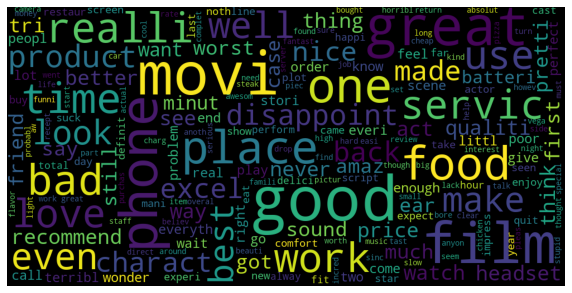

In [18]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1000,height=500,random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

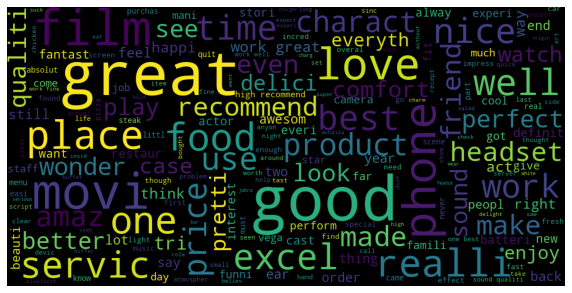

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt  
wordcloud = WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(positive_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud) 
plt.axis('off')
plt.show()


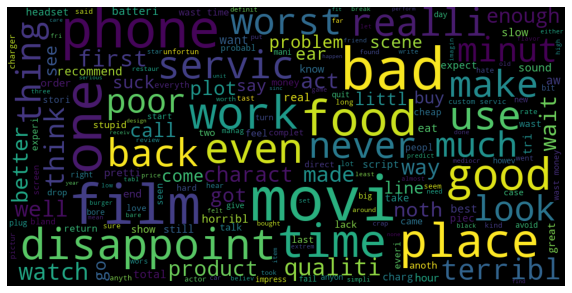

In [20]:
wordcloud=WordCloud(width=1000, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Eliminate rare and frequently occuring words 

### Word2Vec

In [167]:
from gensim import models
tokenized = data_df['Review'].apply(lambda x: x.split())
model_w2v = models.Word2Vec(tokenized,min_count=2,vector_size=500,alpha=0.03, 
                     min_alpha=0.0007)
model_w2v.build_vocab(tokenized,progress_per=10000)
model_w2v.train(tokenized, total_examples=model_w2v.corpus_count, epochs=30, report_delay=1)

(424762, 537600)

In [168]:
model_w2v.wv.most_similar(positive=['terribl'],topn=25)

[('slow', 0.9917249083518982),
 ('fantast', 0.9890669584274292),
 ('mediocr', 0.9890098571777344),
 ('non', 0.9889839887619019),
 ('littl', 0.9887388944625854),
 ('attitud', 0.988588809967041),
 ('par', 0.9881529808044434),
 ('serv', 0.9877058863639832),
 ('phenomen', 0.9875668287277222),
 ('sprint', 0.9875356554985046),
 ('focus', 0.9873577356338501),
 ('toward', 0.9873363375663757),
 ('profess', 0.9872265458106995),
 ('lunch', 0.9871620535850525),
 ('pace', 0.9869109988212585),
 ('atroci', 0.9868522882461548),
 ('typic', 0.986723780632019),
 ('apolog', 0.9866635203361511),
 ('averag', 0.9865884780883789),
 ('pay', 0.9865496158599854),
 ('basic', 0.986505925655365),
 ('damn', 0.9864984750747681),
 ('beyond', 0.9863532781600952),
 ('fast', 0.9862595200538635),
 ('consid', 0.9862591028213501)]

In [169]:
model_w2v.wv.similarity('horribl','terribl')

0.96706367

In [170]:
model_w2v.wv.doesnt_match(['good','horribl','terribl'])

'good'

In [187]:
model_w2v.wv['good']

array([ 1.92419305e-01,  7.80076608e-02,  1.05426699e-01,  8.90576094e-02,
       -4.93295528e-02, -4.90450934e-02,  2.21417397e-02,  1.61883980e-01,
        5.03815413e-02,  7.75307268e-02, -1.77355036e-02,  6.87993243e-02,
        3.13975066e-02,  6.32936135e-02,  2.29000039e-02, -1.81359082e-01,
       -2.22548559e-01, -2.69191898e-02,  1.46535980e-02,  1.33107845e-02,
        1.13835707e-01, -1.09571023e-02,  1.44895062e-01, -2.17946265e-02,
        9.93980840e-02,  4.53828610e-02,  6.67527914e-02,  1.51529415e-02,
       -2.54471749e-01, -4.22134101e-02,  2.80465446e-02, -3.89445871e-02,
       -6.42688125e-02, -5.67722619e-02,  1.76673099e-01,  6.63519278e-02,
        4.91089895e-02, -1.53932273e-02, -3.48370411e-02, -1.40024573e-01,
        1.97475404e-02, -7.66460225e-02, -1.65119216e-01,  1.32871196e-01,
       -9.31715816e-02, -1.00666054e-01, -8.53401944e-02,  4.65829335e-02,
       -1.69700589e-02,  1.83946651e-03, -4.53132577e-02,  1.07450457e-02,
       -6.30653724e-02, -

##### Feature set for word2vec

In [188]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [190]:
wordvec_arrays = np.zeros((len(tokenized), 500)) 
for i in range(len(tokenized)):
    wordvec_arrays[i,:] = word_vector(tokenized[i], 500)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(2769, 500)

In [201]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.163362,0.094238,0.164808,0.129912,-0.058014,-0.154246,-0.007758,0.222537,0.080793,0.045155,...,0.056211,-0.020241,0.180336,-0.050562,0.081279,-0.033730,-0.000554,-0.175374,-0.164834,-0.054719
1,0.181679,0.077600,0.093364,0.083355,-0.033685,-0.055627,0.023830,0.158718,0.070271,0.059393,...,0.082193,0.010970,0.219142,-0.088570,0.018767,-0.027144,0.058851,-0.139249,-0.051755,-0.073810
2,0.156961,0.053715,0.081711,0.078780,-0.053158,-0.069088,0.012669,0.141876,0.054049,0.047887,...,0.051139,-0.005576,0.178589,-0.068390,0.022452,-0.033070,0.048263,-0.120295,-0.069184,-0.054563
3,0.125279,0.115456,0.151731,0.105033,-0.016423,-0.157683,-0.028263,0.218578,0.072230,0.014515,...,0.031144,-0.015901,0.138631,-0.021776,0.084479,-0.007868,-0.005877,-0.169418,-0.171974,-0.066947
4,0.145847,0.041380,0.065541,0.067429,-0.047252,-0.052589,0.015545,0.121084,0.045732,0.045054,...,0.051279,-0.002960,0.168509,-0.066197,0.011199,-0.032423,0.049982,-0.101532,-0.047588,-0.049934


### Doc2Vec

### Count Vectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1,max_df=0.95,ngram_range=(1,3))
x=vectorizer.fit_transform(data_df['Review'])

### Vectorization (Tf-Idf)

In [228]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(min_df=1,max_df=0.95,ngram_range=(1,3))
x=vectorizer.fit_transform(data_df['Review'])


In [22]:
x=pd.DataFrame(x.toarray(),columns=list(vectorizer.get_feature_names()))

In [27]:
X_train

,aailiyah,aailiyah pretti,aailiyah pretti good,abandon,abandon factori,abandon factori readi,abhor,abil,abil actual,abil actual know,...,zillion time,zillion time away,zombi,zombi movi,zombi movi avoid,zombi student,zombi student back,zombiez,zombiez part,zombiez part hellish
810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
y=data_df['Sentiment']
y = np.nan_to_num(y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size = 0.80)

In [32]:

import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report 

models=[MultinomialNB(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(),AdaBoostClassifier()]

for model in models:
    score=cross_val_score(model,X_train,y_train,cv=5)
    model.fit(X_train,y_train.ravel())
    pred=model.predict(X_test)
    print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       284
         1.0       0.77      0.83      0.80       270

    accuracy                           0.80       554
   macro avg       0.80      0.80      0.80       554
weighted avg       0.80      0.80      0.80       554

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81       284
         1.0       0.82      0.76      0.79       270

    accuracy                           0.80       554
   macro avg       0.80      0.80      0.80       554
weighted avg       0.80      0.80      0.80       554

              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       284
         1.0       0.74      0.71      0.72       270

    accuracy                           0.74       554
   macro avg       0.74      0.74      0.74       554
weighted avg       0.74      0.74      0.74       554

              preci